<a href="https://colab.research.google.com/github/nramelia2/MACHINE-LEARNING/blob/main/WEEK%2012_Modern%20Convolution%20Neural%20Networks/Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install d2l==0.17.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Densely Connected Networks (DenseNet)

ResNet significantly changed the view of how to parametrize the functions in deep networks. *DenseNet* (dense convolutional network) is to some extent the logical extension of this :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
To understand how to arrive at it, let us take a small detour to mathematics.


## From ResNet to DenseNet

Recall the Taylor expansion for functions. For the point $x = 0$ it can be written as

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$


The key point is that it decomposes a function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one.
What if we want to capture (not necessarily add) information beyond two terms?
One solution was 
DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/densenet-block.svg?raw=1)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.
As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple:
rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet.](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`


The main components that compose a DenseNet are *dense blocks* and *transition layers*. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large.


## [**Dense Blocks**]

DenseNet uses the modified "batch normalization, activation, and convolution"
structure of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this convolution block structure.


In [5]:
import tensorflow as tf
from d2l import tensorflow as d2l


class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y

A *dense block* consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension.


In [6]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

In the following example,
we [**define a `DenseBlock` instance**] with 2 convolution blocks of 10 output channels.
When using an input with 3 channels, we will get an output with  $3+2\times 10=23$ channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the *growth rate*.


In [7]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

## [**Transition Layers**]

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A *transition layer* is used to control the complexity of the model. It reduces the number of channels by using the $1\times 1$ convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.


In [8]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

[**Apply a transition layer**] with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.


In [9]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

## [**DenseNet Model**]

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as in ResNet.


In [10]:
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

Then, similar to the four modules made up of residual blocks that ResNet uses,
DenseNet uses four dense blocks.
Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in :numref:`sec_resnet`. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels.


In [11]:
def block_2():
    net = block_1()
    # `num_channels`: the current number of channels
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            net.add(TransitionBlock(num_channels))
    return net

Similar to ResNet, a global pooling layer and a fully-connected layer are connected at the end to produce the output.


In [12]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

## [**Training**]

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.


loss 0.138, train acc 0.950, test acc 0.917
1883.7 examples/sec on /GPU:0


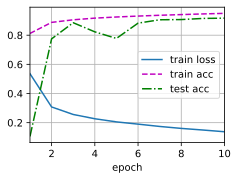

In [14]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Summary

* In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
* The main components that compose DenseNet are dense blocks and transition layers.
* We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.

Reference : https://d2l.ai/chapter_convolutional-modern/densenet.html